# Differential Phase Contrast Tutorial 01

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/ophusgroup/apmc2025-4dstem-workshop/blob/main/notebooks/try-it-yourself/01.dpc_01.ipynb)

This is the first tutorial notebook in the differential phase contrast (DPC) series.  
In this tutorial notebook we will cover:
- Segmented detector differential phase contrast
- Center of mass imaging (pixelated detector DPC)


### Downloads
This tutorial uses the following datasets:
- [dpc_STO_simulation.h5](https://drive.google.com/file/d/1Ml1Ga4-U0ZcTJxq0LVyTJDIVfnBuyd81/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Last updated: 2025 Feb 1

## Introduction

Differential phase contrast (DPC) imaging is a phase retrieval method which attempts to reconstruct the scattering potential of an electron-transparent sample by integrating the gradient arising due to redistribution of the scattered-beam's intensity (measured using its center of mass)

In [1]:
%pip install py4DSTEM > /dev/null 2>&1

In [2]:
import numpy as np
import py4DSTEM
import matplotlib.pyplot as plt

print(py4DSTEM.__version__)
%matplotlib inline

cupyx.jit.rawkernel is experimental. The interface can change in the future.


0.14.18


In [3]:
# Get the 4DSTEM data
py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1Ml1Ga4-U0ZcTJxq0LVyTJDIVfnBuyd81',
    destination = '/content/',
    filename = 'dpc_STO_simulation.h5',
    overwrite=True
)

Downloading...
From: https://drive.google.com/uc?id=1Ml1Ga4-U0ZcTJxq0LVyTJDIVfnBuyd81
To: /content/dpc_STO_simulation.h5
100%|██████████| 75.5M/75.5M [00:00<00:00, 94.2MB/s]


In [4]:
file_path = '/content/'
file_data = file_path + 'dpc_STO_simulation.h5'

dataset = py4DSTEM.read(file_data)
dataset

DataCube( A 4-dimensional array of shape (32, 32, 96, 96) called 'datacube',
          with dimensions:

              Rx = [0.0,0.12328531250000001,0.24657062500000002,...] A
              Ry = [0.0,0.12328531250000001,0.24657062500000002,...] A
              Qx = [0.0,1.0595062826244177,2.1190125652488354,...] mrad
              Qy = [0.0,1.0595062826244177,2.1190125652488354,...] mrad
)

### Virtual segmented detectors
First, let's use the 4D dataset to simulate a (virtual) segmented detector experiment.  
We write a simple function to return each segment as a binary mask

In [5]:
def annular_segmented_detectors(
    energy,
    gpts,
    sampling,
    n_angular_bins,
    rotation_offset = 0,
    inner_radius = 0,
    outer_radius = np.inf,
):
    """ """
    nx,ny = gpts
    sx,sy = sampling
    wavelength = py4DSTEM.process.utils.electron_wavelength_angstrom(energy)

    alpha_x = np.fft.fftfreq(nx,sx)*wavelength
    alpha_y = np.fft.fftfreq(ny,sy)*wavelength

    alpha = np.sqrt(alpha_x[:,None]**2 + alpha_y[None,:]**2)
    radial_mask = ((inner_radius*1e-3 <= alpha) & (alpha < outer_radius*1e-3))

    theta = (np.arctan2(alpha_y[None,:], alpha_x[:,None]) + rotation_offset) % (2 * np.pi)
    angular_bins = np.floor(n_angular_bins * (theta / (2 * np.pi))) + 1
    angular_bins *= radial_mask.astype("int")

    angular_bins = [np.fft.fftshift((angular_bins == i).astype("int")) for i in range(1,n_angular_bins+1)]
    return angular_bins

and test using a 4-segment detector, with inner radius equal to 10 mrad and outer radius equal to 22 mrad.  
_Note:_ Here we manually rotate our detectors by 15 deg, since we simulated our diffraction patterns with that rotation.

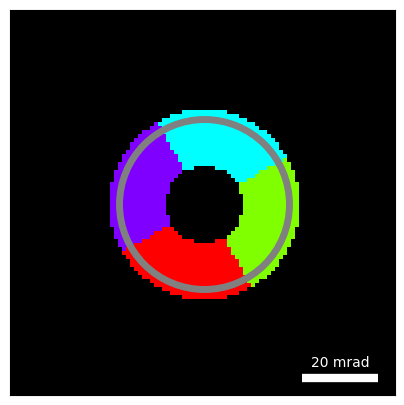

In [6]:
segmented_detectors = annular_segmented_detectors(
    energy=200e3,
    gpts=(96,96),
    sampling=(0.1232853125*2,0.1232853125*2),
    n_angular_bins=4,
    rotation_offset= np.deg2rad(45+15), # 15 degree rotation from simulation
    inner_radius=10, #mrad
    outer_radius=25, #mrad
)

reciprocal_sampling = dataset.calibration.get_Q_pixel_size()
reciprocal_units = dataset.calibration.get_Q_pixel_units()
reciprocal_kwargs = {"pixelsize":reciprocal_sampling,"pixelunits":reciprocal_units,"scalebar":True,"ticks":False}
circle_kwargs = {"center":(48,48),"R":20 * reciprocal_sampling, "alpha":1,"color":"gray","fill":False,"linewidth":5}

# Note: we're also overlaying the mean diffraction pattern for reference
py4DSTEM.visualize.show_circles(
    segmented_detectors,
    combine_images=True,
    **reciprocal_kwargs,
    **circle_kwargs
)

### Segmented detector DPC

The simplest type of differential-phase contrast we can perform is simply summing up the intensity in each segment and subtracting opposing segments for a finite-difference approximation to the gradient

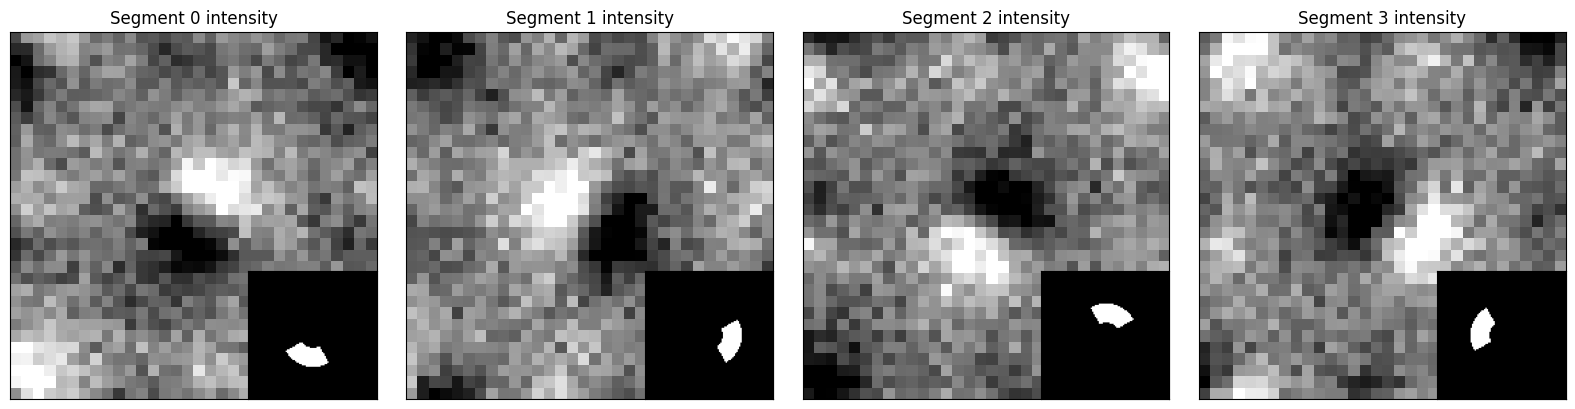

In [7]:
segment_intensities = [(dataset.data * mask).sum((-2,-1)) for mask in segmented_detectors]

fig,axs = plt.subplots(1,4,figsize=(16,4))

py4DSTEM.show(
    segment_intensities,
    ticks=False,
    figax=(fig,axs),
    title= [f"Segment {i} intensity" for i in range(4)]
)

for ax, detector in zip(axs,segmented_detectors):
    ax_in = ax.inset_axes(
        [0.65,0,0.35,0.35],
    )
    py4DSTEM.show(
        detector,
        figax=(fig,ax_in),
        ticks=False,
    )

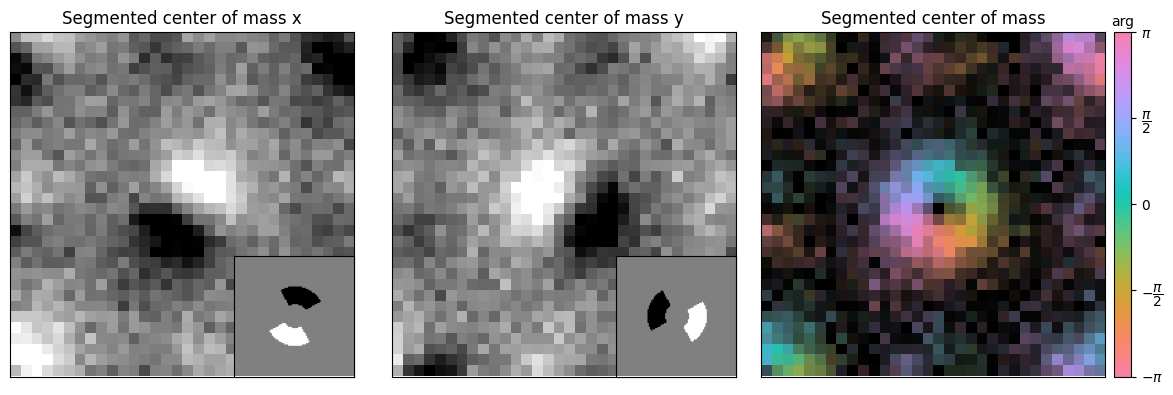

In [8]:
segmented_com_x = segment_intensities[0] - segment_intensities[2]
segmented_com_y = segment_intensities[1] - segment_intensities[3]

fig,axs = plt.subplots(1,3,figsize=(12,4))

py4DSTEM.show(
    [segmented_com_x,segmented_com_y],
    ticks=False,
    figax=(fig,axs[:2]),
    title = ["Segmented center of mass x","Segmented center of mass y"]
)

detector_insets = [
    segmented_detectors[0]-segmented_detectors[2],
    segmented_detectors[1]-segmented_detectors[3]
]

for ax, detector in zip(axs[:2],detector_insets):
    ax_in = ax.inset_axes(
        [0.65,0,0.35,0.35],
    )
    py4DSTEM.show(
        detector,
        figax=(fig,ax_in),
        ticks=False,
    )

py4DSTEM.show_complex(
    segmented_com_x + 1j*segmented_com_y,
    ticks=False,
    figax=(fig,axs[-1]),
    title= "Segmented center of mass"
)


This works reasonably well, but notice our CoM is not exactly centered/aligned. This is a consequence of our detectors not being entirely centered due to the even grid.

A slightly better way to compute the center of mass is to weigh the intensity of each segment by its detector's center-of-mass and sum them together.

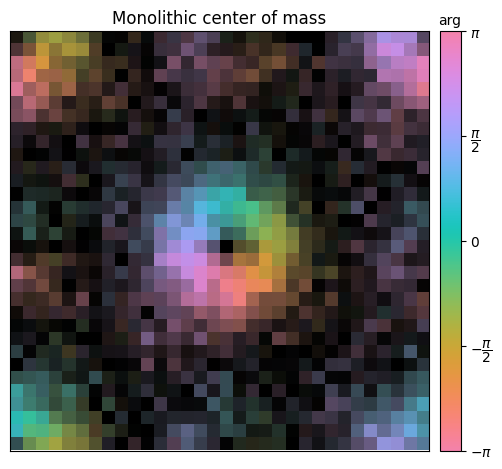

In [9]:
monolithic_com_x = np.zeros((32,32))
monolithic_com_y = np.zeros((32,32))
dp_center = (48,48)

for segment in range(4):
    kxa,kya=np.where(segmented_detectors[segment])
    patches= dataset.data[:,:,kxa,kya].sum(-1)
    monolithic_com_x += patches * (kxa.mean()-dp_center[0])
    monolithic_com_y += patches * (kya.mean()-dp_center[1])

py4DSTEM.show_complex(
    monolithic_com_x + 1j*monolithic_com_y,
    ticks=False,
    title= "Monolithic center of mass"
)

Taking the above procedure to its logical conclusion, we would obtain a better estimate of the center of mass if weighted each pixel in the 4D dataset by its pixel location. This is what pixelated DPC or center-of-mass imaging does!

### Center of Mass Imaging
In py4DSTEM, this is implemented using the `DPC` class

Calculating center of mass: 100%|██████████| 1024/1024 [00:00<00:00, 29770.96probe position/s]
Best fit rotation = -15 degrees.


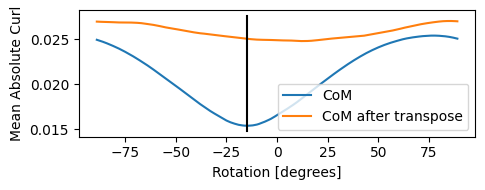

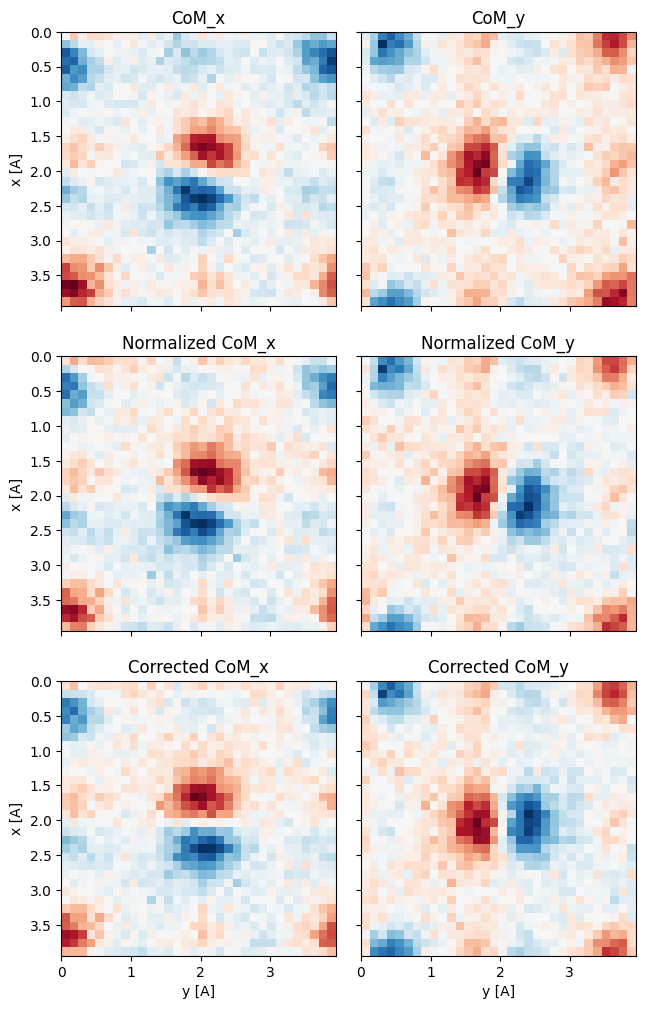

In [10]:
dpc = py4DSTEM.process.phase.DPC(
    energy = 200e3,
    datacube = dataset,
).preprocess(
    plot_center_of_mass='all',
)

The first thing the preprocessing step does is solve for the relative rotational offset between the real-space scan coordinate system and the detector coordinate system, which it correctly solves as -15 degrees.  
The way it does this is by minimizing the curl of the center of mass vector. Recall that the center of mass is related to the gradient of the electrostatic potential, and according to calculus the curl of a gradient of a scalar function is zero!

The next set of plots are diagnostic:
- the measured CoM vector is displayed in the top row (with the 15 degree rotation apparent)
- the second row plots the normalized CoM (i.e. after accounting for any descan/origin off-centering, which we don't have in our case)
- finally, the last row plots the corrected CoM after we've accounted for the rotational offset

We can plot this corrected CoM vector on the complex plane, and indeed the resulting image is much less noisy

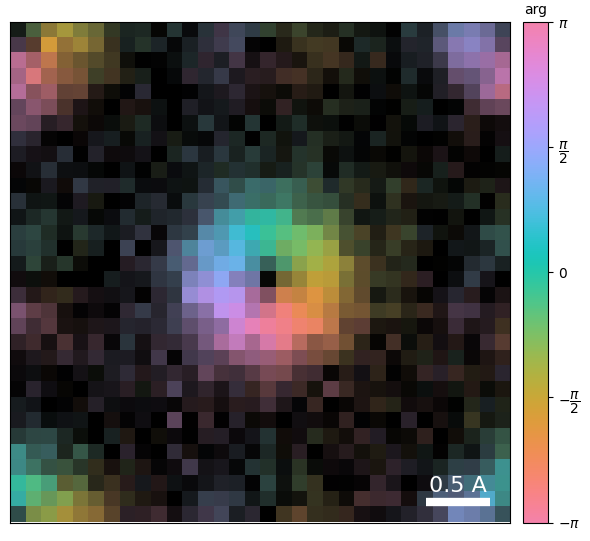

In [11]:
dpc.show_complex_CoM()

### Integrated Center of Mass
In order to obtain an estimate for the electrostatic potential, we need to integrate the vectorial center of mass images.  
In py4DSTEM this is done iteratively in Fourier space. To reduce boundary effects, we pad the reconstruction during the iteration.

Reconstructing phase:  50%|█████     | 32/64 [00:00<00:00, 2412.08 iter/s]
Step-size has decreased below stopping criterion 1e-06.


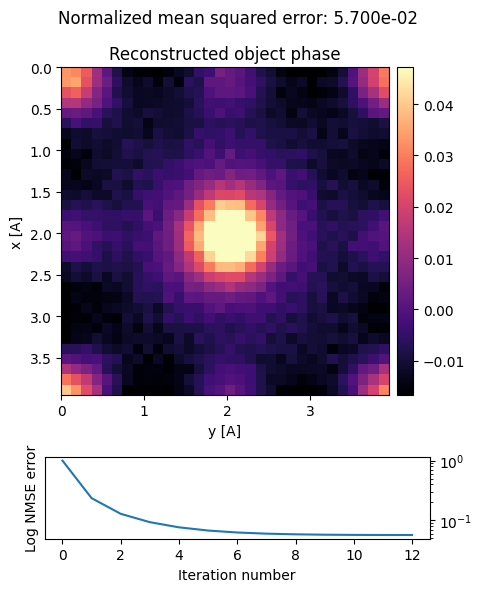

In [12]:
dpc = dpc.reconstruct(
    reset = True,
).visualize(
)

Indeed, we obtain a faithul reconstruction of [100] STO!